In [1]:
# hide
%load_ext autoreload
%autoreload 2

# Adult income dataset

Here we wll study the Adult Income Dataset and see how we can apply Homomorphic Random Forest to it.

## Data loading

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)

df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# df = df.sample(frac=0.1, random_state=1)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

## Data preprocessing

Because we need our data to be in the range$[-1,1]$ at the beginning, we will create a preprocessing pipeline using sklearn Pipelines. 

It will apply a LabelEncoder on categorical columns, before using it in a MinMaxScaler.

In [3]:
from cryptotree.preprocessing import Featurizer

Now that we have defined the featurizer, we can use it on our dataset.

In [4]:
categorical_columns = ["WorkClass","Education","MaritalStatus", "Occupation", "Relationship", 
                       "Race", "Gender", "NativeCountry"]

pipe = Featurizer(categorical_columns)

In [5]:
X_train_normalized = pipe.fit_transform(X_train)

We can have a look and check that input is in $[-1,1]$.

In [6]:
X_train_normalized[:2]

array([[0.30136986, 0.75      , 0.11883726, 0.06666667, 0.4       ,
        0.33333333, 1.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.39795918, 0.95      ],
       [0.50684932, 0.75      , 0.06202921, 0.6       , 0.8       ,
        0.33333333, 0.28571429, 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.39795918, 0.95      ]])

## Neural Random Forest

In [7]:
import torch
import numpy as np

Now that data has been preprocessed, we can feed it to a Neural Random Forest.

Here we can have a look at the activation function we will use, for instance sigmoid.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbbb5a2f470>)

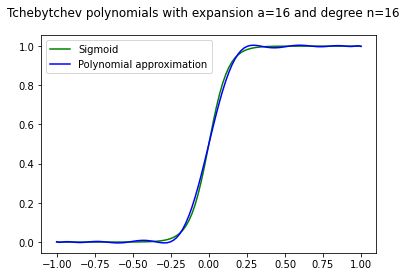

In [8]:
from cryptotree.tree import NeuralRandomForest, SigmoidTreeMaker, TanhTreeMaker
from cryptotree.polynomials import plot_graph_function_approximation

max_depth = 4

dilatation_factor = 16
polynomial_degree = dilatation_factor

plot_graph_function_approximation(torch.sigmoid,
                                  dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

Now that we have te parameters of dilation and polynomial degree for the activation functions, we can create the tree makers.

In [9]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

We can fit a regular sklearn Random Forest now.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

From the regular RF, we can define the Neural Random Forest, with sigmoid and tanh activations.

### Without finetuning

In [11]:
estimators = rf.estimators_

In [12]:
sigmoid_neural_rf = NeuralRandomForest(estimators, sigmoid_tree_maker)
tanh_neural_rf = NeuralRandomForest(estimators, tanh_tree_maker)

In [13]:
with torch.no_grad():
    sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

pred = rf.predict(X_train_normalized)
print(f"Original accuracy : {(pred == y_train).mean()}")

print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_train).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_train).mean()}")

print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")

Original accuracy : 0.8373003685503686
Accuracy of sigmoid  : 0.24393427518427518
Accuracy of tanh : 0.7560657248157249
Match between sigmoid and original : 0.10565110565110565
Match between tanh and original : 0.8943488943488943


We can see that there is a discrepancy between the original Random Forest and the neural ones, especially for the sigmoid one.

Nonetheless we can correct this error by finetuning the final layer of our neural networks to take into account the fact that due to using activation functions not sharp enough.

### With finetuning

Because we need to make sure that at each step of the Neural Network the output is in $[-1,1]$, to be able to use the polynomial approximation of the activation, we can only safely train the last layer.

To do so we will use Pytorch and [fastai](https://github.com/fastai/fastai).

Here we first define our Pytorch Dataset.

In [14]:
from torch.utils import data
import numpy as np

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

Then we split our training data into training and validation.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
X_train_normalized, X_valid_normalized, y_train, y_valid = train_test_split(pipe.transform(X_train), 
                                                                            y_train,
                                                                            train_size=0.8)

Then we create the Pytorch dataloaders.

In [16]:
train_ds = TabularDataset(X_train_normalized, y_train.values)
valid_ds = TabularDataset(X_valid_normalized, y_valid.values)

In [17]:
bs = 128

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

Here we will just define the model, which is a sigmoid Neural Random Forest.

In [18]:
tree_maker = tanh_tree_maker

model = NeuralRandomForest(rf.estimators_, tree_maker=tree_maker)

Because we only want to train the last layer, we will freeze the first two layers and check they are frozen.

In [19]:
model.freeze_layer("comparator")
model.freeze_layer("matcher")

for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([14, 15, 100]) False
torch.Size([15, 100]) False
torch.Size([16, 15, 100]) False
torch.Size([16, 100]) False
torch.Size([2, 16, 100]) True
torch.Size([2, 100]) True


In [20]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8379882906229005
Accuracy : 0.7569824359343507
Same output : 0.8951914771091276


Now we can define our fastai Learner, with the dataset, the model, and the loss function, which is a Label Smoothing Cross Entropy here.

In [21]:
from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from cryptotree.tree import CrossEntropyLabelSmoothing
import torch.nn as nn

data = DataBunch(train_dl, valid_dl,fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, model, loss_func=criterion, metrics=accuracy)

We will use fastai lr finder to have an idea of what learning rate to choose.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


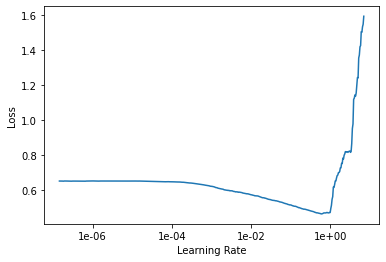

In [22]:
learn.lr_find(num_it=500)
learn.recorder.plot()

Here we can see that a good learning rate should be around 1e-1.

We can now fine tune our model.

In [23]:
learn.fit_one_cycle(5,1e-1 / 2)

epoch,train_loss,valid_loss,accuracy,time
0,0.475183,0.449700,0.821113,00:02
1,0.434638,0.431633,0.838388,00:02
2,0.426477,0.440141,0.834165,00:02
3,0.422974,0.425151,0.843954,00:02
4,0.422855,0.423817,0.845681,00:02


Here we can have a look at the performance of the Neural Random Forest tuned with respect to the original sklearn Random Forest.

In [24]:
pred = rf.predict(X_valid_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_valid_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8345489443378119
Accuracy : 0.8456813819577735
Same output : 0.9274472168905951


## Homomorphic Random Forest

Now that we have seen how a Neural Random Forest can be obtained and fine tuned from a regular sklearn Random Forest, we can now see how its Homomorphic Random Forest counterpart performs.

To do so, we must first initialize the parameters of the CKKS SEAL library, and choose the polynomial activation function we want. Here we will use the same activation function as the above Neural Random Forest.

In [25]:
import numpy as np 

dilatation_factor = 16
degree = dilatation_factor

PRECISION_BITS = 28
UPPER_BITS = 9

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 3

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 16384

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]
438


Now we just need to use the parameters defined above to populate our environment with SEAL context.

In [26]:
from cryptotree.seal_helper import create_seal_globals, append_globals_to_builtins
import builtins

create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS, use_symmetric_key=False)
append_globals_to_builtins(globals(), builtins)

We can then create our Homomorphic Random Forest from the Neural Random Forest we fine tuned earlier.

We first have to extract the weights using the Homomorphic Random Forest class, and pass it to the Homomorphic Tree Evaluator which will do the computation, using the polynomial activation given, and the SEAL context.

A featurizer is also created for the client side, in order to preprocess, encode and encrypt the data.

In [27]:
from cryptotree.cryptotree import HomomorphicNeuralRandomForest, HomomorphicTreeEvaluator, HomomorphicTreeFeaturizer
from cryptotree.polynomials import polyeval_tree

h_rf = HomomorphicNeuralRandomForest(model)

tree_evaluator = HomomorphicTreeEvaluator.from_model(h_rf, tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

homomorphic_featurizer = HomomorphicTreeFeaturizer(h_rf.return_comparator(), encoder, encryptor, scale)

Now we can take some data, encrypt it, and pass it to our Homorphic Tree Evaluator : 

In [28]:
i = 0

x = X_train_normalized[i]
ctx = homomorphic_featurizer.encrypt(x)

outputs = tree_evaluator(ctx)

We can decrypt and decode the data to see the output :

In [29]:
import tenseal.sealapi as seal

ptx = seal.Plaintext()
decryptor.decrypt(outputs, ptx)

homomorphic_pred = encoder.decode_double(ptx)[:2]

We can see what was the original output, if we had used only the Neural Random Forest : 

In [30]:
x = X_train_normalized[i]

pred = rf.predict_proba(x.reshape(1,-1))
neural_pred = model(torch.tensor(x).float().unsqueeze(0))

print(f"Original Random Forest output : {pred}")
print(f"Neural Random Forest output : {neural_pred.detach()}")
print(f"Homomorphic Random Forest output : {homomorphic_pred}")

Original Random Forest output : [[0.830971 0.169029]]
Neural Random Forest output : tensor([[ 1.0418, -0.8052]])
Homomorphic Random Forest output : [1.0742285425491416, -0.8491698612169115]


Here we can see our Neural Random Forest, and Homomorphic Random Forest have very similar outputs.

## Comparison between models

We will now compare a linear model, a RF, a NRF and a HRF. 

Because computation are done one at a time with HRF, we will use Fastai `parallel` to speedup inference taking advantage of the multiple CPUs.

In [30]:
from fastai.core import parallel
import multiprocessing
import tenseal.sealapi as seal

def predict(x, index):
    """Performs HRF prediction"""
    
    # We first encrypt and evaluate our model on it
    ctx = homomorphic_featurizer.encrypt(x)
    outputs = tree_evaluator(ctx)
    
    # We then decrypt it and get the first 2 values which are the classes scores
    ptx = seal.Plaintext()
    decryptor.decrypt(outputs, ptx)
    
    homomorphic_pred = encoder.decode_double(ptx)[:2]
    homomorphic_pred = np.argmax(homomorphic_pred)
    
    return index, homomorphic_pred

# We get the number of cores
cores = multiprocessing.cpu_count()

# We compute the outputs
hrf_pred = parallel(predict, X_valid_normalized, max_workers=cores)

# Because the outputs are unordered we must first sort by index then take the predictions
hrf_pred = np.array(sorted(hrf_pred, key = lambda x:x[0]))[:,1]

We compute the predictions of the NRF.

In [ ]:
outputs = []

for x,y in valid_dl:
    with torch.no_grad():
        pred = model(x)
    outputs.append(pred)
    
nrf_pred = torch.cat(outputs).argmax(dim=1).numpy()

Finally we compute the predictions of logistic regression and RF.

In [ ]:
from sklearn.linear_model import LogisticRegression

linear = LogisticRegression()
linear.fit(X_train_normalized, y_train)

# We compute the linear preds
linear_pred = linear.predict(X_valid_normalized)

# We compute the random forest predictions
rf_pred = rf.predict(X_valid_normalized)

We can compute all metrics now.

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred, y):
    """Computes all the metrics between predictions and real values"""
    accuracy = accuracy_score(pred,y)
    precision = precision_score(pred,y)
    recall = recall_score(pred,y)
    f1 = f1_score(pred, y)
    return dict(accuracy=accuracy, precision=precision, recall=recall, f1=f1)

models = dict(nrf=nrf_pred, hrf=hrf_pred, rf=rf_pred, linear=linear_pred)

outputs = []
for name, pred in models.items():
    metrics = compute_metrics(pred, y_valid)
    metrics["model"] = name
    outputs.append(metrics)

In [49]:
outputs = pd.DataFrame(outputs)

In [4]:
outputs

,accuracy,precision,recall,f1,model
0,0.845681,0.547287,0.762419,0.637184,nrf
1,0.842994,0.491473,0.796482,0.607862,hrf
2,0.834549,0.386047,0.876761,0.536060,rf
3,0.818618,0.431783,0.724317,0.541039,linear


In [51]:
outputs.to_csv("results.csv", index = None)

Finally we can have a look at how similar NRF and HRF predictions are.

In [52]:
(nrf_pred == hrf_pred).mean()

0.9742802303262956

In [35]:
torch.save(model.state_dict(), "model.pkl")